# Week 11 Seminar Notebook: Training a Softmax Classifier





Now we generate a full dataset for softmax classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


## Create simulated data
np.random.seed(10)
w1_center = (1, 3)
w2_center = (3, 1)
w3_center = (1, 1)
w4_center = (3, 3)

x=np.concatenate((np.random.normal(loc=w1_center,size=(20,2)),np.random.normal(loc=w2_center,size=(20,2)),np.random.normal(loc=w3_center,size=(10,2)),np.random.normal(loc=w4_center,size=(10,2))))

labs=np.repeat([0,1,2],[20,20,20],axis=0)
y=np.repeat(np.diag((1,1,1)),[20,20,20],axis=0)
x=x.T
x=np.array([x[0],x[1],[1] * len(x[0])])



(0.0, 5.0)

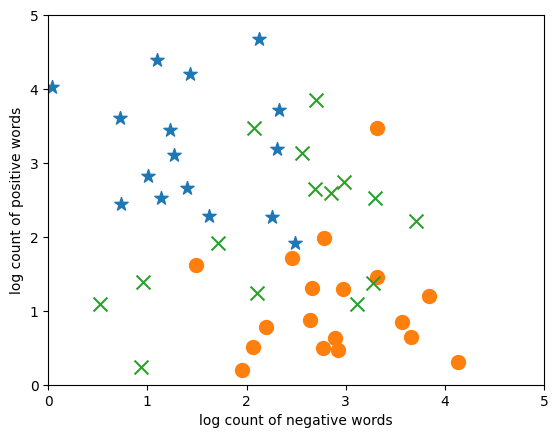

In [ ]:
plt.scatter(x[0][labs==0], x[1][labs==0], marker='*', s=100)
plt.scatter(x[0][labs==1], x[1][labs==1], marker='o', s=100)
plt.scatter(x[0][labs==2], x[1][labs==2], marker='x', s=100)
plt.xlabel("log count of negative words")
plt.ylabel("log count of positive words")
plt.xlim((0,5))
plt.ylim((0,5))


Problem 3. Given the data generated above write the code to train a multiclass classifier to convergence.

In [ ]:
x=x.T

Text(0, 0.5, 'loss')

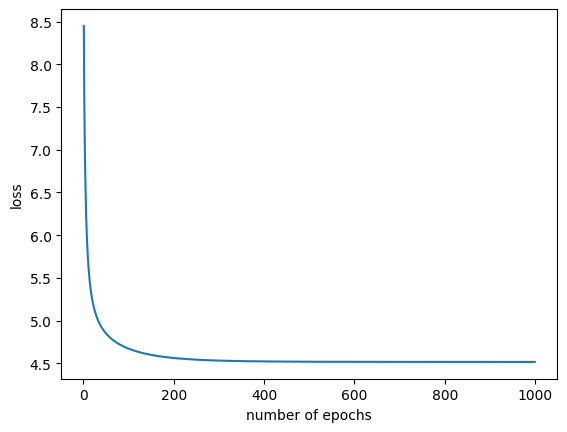

In [ ]:
np.random.seed(10)
n_iters = 1000
num_features=3
num_classes=3
num_samples = len(y)
weights = np.random.rand(num_classes,num_features)
lr=0.2
logistic_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))


import random
batch_size=12
batch_assignments=[0,1,2,3,4]*batch_size
random.shuffle(batch_assignments)

for i in range(n_iters):
   cumulative_loss = 0.0
   for j in range(int(len(y)/batch_size)):
       input = x[[ind for ind, v in enumerate(batch_assignments) if v == j]]
       targets = y[[ind for ind, v in enumerate(batch_assignments) if v == j]]
       z= input.dot(weights)
       z_sum=np.exp(z).sum(axis=1)
       q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)])
       #print(q)
       loss=np.mean(-np.log2((np.sum((targets*q),axis=1))))
       cumulative_loss+=loss
       dw=input.T.dot((q-targets))/num_samples
       weights=(weights - (dw*lr))
   logistic_loss.append(cumulative_loss)
plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

Problem 4.  Write code to calculate the multiclass precision and recall using macroaveraging (see week 7 lectures slides pt 2 for a definition). The code for calculating precision and recall for binary classifiers from week 8 will provide a useful starting point.

## Building an intent classifier

Below you can find data for the task of intent classification. This is an important step in modern task-based dialogue systems - given a particular piece of input from the speaker, the system tries to determine what goal the speaker is trying to achieve, in order that it can then produce an appropriate response.

The data set pairs 2100 reviews with one of seven different intents:

'PlayMusic', e.g. "play easy listening"  \
'AddToPlaylist' e.g. "please add this song to road trip" \
'RateBook' e.g. "give this novel 5 stars" \
'SearchScreeningEvent' e.g. "give me a list of local movie times" \
'BookRestaurant' e.g. "i'd like a table for four at 7pm at Asti" \
'GetWeather' e.g. "what's it like outside" \
'SearchCreativeWork' "show me the new James Bond trailer"

To import the data please run the following cells.


In [1]:
! wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/intent_classification.csv
# Or in Jupyter
#from urllib.request import urlretrieve
#url = "https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/intent_classification.csv"
#filename="intent_classification.csv"
#urlretrieve(url, filename)

--2025-12-05 18:05:08--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/intent_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130852 (128K) [text/plain]
Saving to: ‘intent_classification.csv’

intent_classificati 100%[===================>] 127.79K  --.-KB/s    in 0.003s  

2025-12-05 18:05:08 (43.2 MB/s) - ‘intent_classification.csv’ saved [130852/130852]



In [2]:
# Import the data into utterances and labels lists
utterances=[]
labels=[]

with open("intent_classification.csv") as f:
   # iterate over the lines in the file
   for line in f.readlines()[1:]:
        # split the current line into a list of two element - the review and the label
        fields = line.rstrip().split(',')
        # put the current review in the reviews list
        utterances.append(fields[0])
        # put the current sentiment rating in the labels list
        labels.append(fields[1])

In [5]:
## Select vocabulary for inclusion in one-hot representations
from collections import Counter
import re
import numpy as np
# Tokenise the text, turning a list of strings into a list of lists of tokens. We use very naive space-based tokenisation.
tokenized_sents = [re.findall("[^ ]+",txt) for txt in utterances]
# Collapse all tokens into a single list
tokens=[]
for s in tokenized_sents:
      tokens.extend(s)
# Count the tokens in the tokens list. The returns a list of tuples of each token and count
counts=Counter(tokens)
# Sort the tuples. The reverse argument instructs to put most frequent first rather than last (which is the default)
so=sorted(counts.items(), key=lambda item: item[1], reverse=True)
# Extract the list of tokens, by transposing the list of lists so that there is a list of tokens a list of counts and then just selecting the former
so=list(zip(*so))[0]
# Select the firs 5000 words in the list
type_list=so[0:2500]

In [6]:
# Create a 2100 x 2500 matrix of zeros
M = np.zeros((len(utterances), len(type_list)))
#iterate over the reviews
for i, utt in enumerate(utterances):
    # Tokenise the current review:
    tokens = re.findall("[^ ]+",utt)
    # iterate over the words in our type list (the set of 5000 words):
    for j,t in enumerate(type_list):
        # if the current word j occurs in the current review i then set the matrix element at i,j to be one. Otherwise leave as zero.
        if t in tokens:
              M[i,j] = 1

In [7]:
train_ints=np.random.choice(len(utterances),int(len(utterances)*0.8),replace=False)
remaining_ints=list(set(range(0,len(utterances))) - set(train_ints))
test_ints=np.random.choice(len(remaining_ints),int(len(remaining_ints)*0.5),replace=False)
dev_ints=list(set(range(0,len(remaining_ints))) - set(test_ints))

In [8]:

### Generate one-hot encoded input matrices for training, development and test
M_train = np.array(M[train_ints,]).T
M_test = np.array(M[test_ints,]).T
M_dev = np.array(M[dev_ints,]).T

unique_labels=list(set(labels))
unique_one_hot=np.diag(np.ones(len(unique_labels)))

labels_train = [labels[i] for i in train_ints]
labels_test = [labels[i] for i in test_ints]
labels_dev = [labels[i] for i in dev_ints]

### Generate one-hot encoded target output matrices for training, development and test
y_train=np.array([list(unique_one_hot[k]) for k in [unique_labels.index(x) for x in labels_train]]).T
y_test=np.array([list(unique_one_hot[k]) for k in [unique_labels.index(x) for x in labels_test]]).T
y_dev=np.array([list(unique_one_hot[k]) for k in [unique_labels.index(x) for x in labels_dev]]).T



The data has been split into training set of 1680, a development set of 210 and a test set of 210.

Problem 5. Train a softmax classifier for this task on the training set. You can test performance on the development set as you go.

In [26]:
M_train.shape

(2500, 1680)

In [40]:
(q-y_train).T

array([[ 2.35734855e-04, -9.99370193e-01,  4.34747081e-04, ...,
         1.41366439e-04,  3.37051369e-04,  3.67095292e-04],
       [ 8.77409354e-04,  1.52076179e-04,  7.75935028e-04, ...,
         3.02165890e-04,  5.79370123e-04,  1.20094887e-03],
       [ 2.49882238e-04,  9.26925143e-04,  3.08103433e-03, ...,
         1.00669863e-03,  4.38267790e-04,  4.27227155e-04],
       ...,
       [-9.99942439e-01,  1.42168359e-04,  9.81410376e-05, ...,
         9.41761717e-05,  1.46273633e-05,  3.41817288e-04],
       [ 3.35821744e-06, -9.99989851e-01,  3.04383942e-05, ...,
         3.86344210e-05,  1.06569002e-05,  1.54316280e-05],
       [-9.99994440e-01,  5.52288204e-06,  6.50975718e-06, ...,
         5.14408646e-06,  3.52162205e-06,  6.76802068e-06]])

In [39]:
M_train.shape

(2500, 1680)

Text(0, 0.5, 'loss')

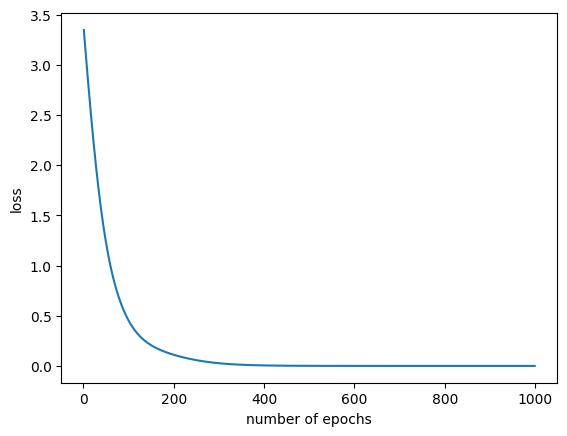

In [56]:
import matplotlib.pyplot as plt

np.random.seed(10)
n_iters = 1000
num_features=2500
num_classes=7
num_samples = len(y_train)
weights = np.random.rand(num_classes,num_features)
lr=0.001
logistic_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))
#x=x.T
for i in range(n_iters):

    z= weights.dot(M_train)
    z_sum=np.exp(z).sum(axis=1)
    q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)])
    loss=np.mean(-np.log2((np.sum((y_train*q),axis=1))))

    logistic_loss.append(loss)

    dw=M_train.dot((q-y_train).T)/num_samples
    weights=(weights - (dw*lr).T)

plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

Problem 6. Evaluate your classifier, by calculating precision and recall on the test set.

In [57]:
z = weights.dot(M_test)
z

array([[  9.87658903, 129.26703309,   1.3000944 , ...,  25.25799748,
         24.14874048,  17.50831249],
       [  8.10137603,  14.47040114,  11.34518934, ...,  65.51400503,
         48.27206215,  23.63101885],
       [ 11.31958928,   9.6624267 ,  26.35203622, ...,  43.59151058,
         33.71390108,  36.62931237],
       ...,
       [ 15.29365871,  17.84526397,   1.05206047, ...,  21.43601811,
         20.25855975,  15.57056848],
       [ 71.02331786,   9.37865385,   1.34322482, ...,  26.14042688,
         25.89588125,  46.07342708],
       [  6.15719503,  24.36594032,   0.93488012, ...,  45.79518777,
         28.18815671,  34.66061351]])

In [59]:
weights

array([[1.52090546e+01, 4.44473892e+00, 3.43506298e+01, ...,
        6.30586436e-01, 6.02830669e-01, 5.99813209e-02],
       [2.55674892e+01, 6.49429267e+00, 4.85854847e+00, ...,
        2.91433688e-02, 9.55820264e-01, 3.12157062e-01],
       [2.07212309e+01, 2.81112270e+00, 3.93887460e+00, ...,
        9.37929233e-01, 4.93634581e-01, 2.91111840e-01],
       ...,
       [1.08777877e+01, 7.40378351e+00, 3.88056453e+00, ...,
        6.44485707e-02, 3.86680632e-01, 7.35609673e-01],
       [1.93187006e+01, 2.11439363e+00, 3.66764795e+00, ...,
        8.93222099e-01, 3.07149921e-01, 2.25715044e-01],
       [1.59472639e+01, 1.42739632e+01, 6.28755690e+00, ...,
        7.65207588e-01, 4.24831415e-01, 8.37257910e-01]])

In [60]:
q

array([[5.98713720e-59, 4.24453633e-07, 1.12848273e-62, ...,
        2.86602533e-52, 9.45226373e-53, 1.23490798e-55],
       [6.42863650e-29, 3.75103686e-26, 1.64774155e-27, ...,
        5.52213266e-04, 1.79484186e-11, 3.56908632e-22],
       [1.87499730e-30, 3.57523083e-31, 6.33154075e-24, ...,
        1.94320218e-16, 9.97072390e-21, 1.84023685e-19],
       ...,
       [2.35126793e-23, 3.01613103e-22, 1.53551687e-29, ...,
        1.09369169e-20, 3.36923455e-21, 3.10143376e-23],
       [2.18322416e-17, 3.69114336e-44, 1.19513901e-47, ...,
        7.02597248e-37, 5.50175985e-37, 3.18785411e-28],
       [3.25202263e-49, 2.63094132e-41, 1.75440968e-51, ...,
        5.32985115e-32, 1.20248218e-39, 7.78091948e-37]])

In [63]:
np.argmax(q,axis=0)

array([5, 0, 2, 1, 1, 4, 1, 1, 2, 0, 4, 2, 2, 6, 1, 3, 1, 0, 2, 4, 3, 0,
       1, 6, 6, 1, 5, 5, 0, 1, 5, 4, 3, 5, 4, 1, 5, 0, 1, 1, 6, 0, 4, 0,
       0, 2, 0, 4, 0, 4, 0, 5, 4, 2, 3, 0, 4, 5, 0, 1, 4, 1, 5, 2, 6, 1,
       3, 3, 1, 1, 6, 6, 1, 4, 1, 5, 2, 5, 1, 2, 1, 5, 4, 4, 0, 4, 2, 1,
       1, 2, 4, 4, 1, 4, 2, 1, 6, 1, 4, 3, 2, 1, 4, 1, 4, 1, 6, 1, 2, 1,
       0, 1, 4, 4, 3, 5, 5, 1, 0, 4, 4, 2, 4, 4, 6, 1, 2, 5, 2, 0, 1, 2,
       5, 0, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 4, 3, 1, 1, 6, 5, 4, 1, 4, 4,
       5, 1, 4, 0, 3, 4, 4, 0, 1, 1, 0, 0, 5, 0, 1, 1, 0, 4, 4, 6, 1, 2,
       2, 4, 4, 6, 2, 4, 5, 4, 4, 1, 0, 4, 5, 4, 4, 3, 0, 3, 0, 2, 0, 4,
       1, 2, 1, 0, 1, 4, 6, 5, 0, 1, 1, 3])

In [64]:
z = weights.dot(M_test)
z_sum=np.exp(z).sum(axis=1)
q=np.array([list(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)])
y_test_pred=np.argmax(q,axis=0)
y_test_true=np.argmax(y_test,axis=0)
print(y_test_pred)
print(y_test_true)

TP=[]
for j in range(7):
 TP.append(np.sum(np.array([int(s == j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))

FP=[]
for j in range(7):
 FP.append(np.sum(np.array([int(s == j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))

FN=[]
for j in range(7):
 FN.append(np.sum(np.array([int(s != j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))


PRECISION=np.array(TP)/(np.array(TP)+np.array(FP))
RECALL=np.array(TP)/(np.array(TP)+np.array(FN))

PRECISION_MACROAVERAGE=np.mean(PRECISION)
print(PRECISION_MACROAVERAGE)

RECALL_MACROAVERAGE=np.mean(RECALL)
print(RECALL_MACROAVERAGE)

[5 0 2 1 1 4 1 1 2 0 4 2 2 6 1 3 1 0 2 4 3 0 1 6 6 1 5 5 0 1 5 4 3 5 4 1 5
 0 1 1 6 0 4 0 0 2 0 4 0 4 0 5 4 2 3 0 4 5 0 1 4 1 5 2 6 1 3 3 1 1 6 6 1 4
 1 5 2 5 1 2 1 5 4 4 0 4 2 1 1 2 4 4 1 4 2 1 6 1 4 3 2 1 4 1 4 1 6 1 2 1 0
 1 4 4 3 5 5 1 0 4 4 2 4 4 6 1 2 5 2 0 1 2 5 0 2 2 1 2 0 1 1 1 1 2 4 3 1 1
 6 5 4 1 4 4 5 1 4 0 3 4 4 0 1 1 0 0 5 0 1 1 0 4 4 6 1 2 2 4 4 6 2 4 5 4 4
 1 0 4 5 4 4 3 0 3 0 2 0 4 1 2 1 0 1 4 6 5 0 1 1 3]
[5 0 2 1 1 0 1 1 2 0 6 2 2 6 0 3 6 0 2 5 3 0 6 6 6 3 5 5 0 3 5 4 3 5 4 1 5
 0 1 1 6 0 4 0 0 2 0 4 0 4 0 5 4 2 3 0 0 5 0 1 6 3 5 2 6 1 3 3 0 6 6 6 1 4
 2 5 2 5 1 2 6 5 4 4 0 6 2 1 3 2 4 4 1 0 2 1 6 1 4 3 2 6 4 1 4 6 6 3 2 2 0
 1 6 4 3 5 5 1 0 4 4 2 4 4 6 6 2 5 2 0 5 5 5 0 2 2 1 2 0 6 1 1 1 2 4 3 1 1
 6 5 6 1 0 5 5 3 4 0 3 4 6 0 1 6 0 0 5 0 1 3 0 4 4 6 1 2 2 2 0 6 2 5 5 3 4
 5 0 4 5 3 6 3 0 5 0 2 0 6 6 2 1 0 2 4 6 5 0 1 1 3]
0.862565074676876
0.7798614033617212
